In [1]:
import torch
import torch.nn as nn
import torchvision.ops as ops
from typing import List, Tuple, Union
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from torchvision import transforms
from ultralytics import YOLO

def yolov11n_inference(
    model: nn.Module,
    images: Union[torch.Tensor, List[torch.Tensor]], 
    conf_threshold: float = 0.25,
    iou_threshold: float = 0.45
) -> List[torch.Tensor]:
    """
    Summary: Performs batch inference using YOLOv11n model with NMS

    Args:
        model (nn.Module): YOLOv11n model instance
        images (Union[torch.Tensor, List[torch.Tensor]]): Input images tensor of shape (B,C,H,W) or list of image tensors
        conf_threshold (float): Confidence threshold for filtering detections
        iou_threshold (float): IoU threshold for NMS

    Returns:
        List[torch.Tensor]: List of tensors containing filtered predictions for each image
                           Each tensor has shape (num_boxes, 6) with format [x1,y1,x2,y2,conf,class_id]
    """
    # Ensure model is in eval mode
    model.eval()
    
    # Handle both single tensor and list inputs
    if isinstance(images, torch.Tensor):
        batch_tensor = images
    else:
        # Pad images to same size if needed
        max_h = max(img.shape[-2] for img in images)
        max_w = max(img.shape[-1] for img in images)
        batch_tensor = torch.zeros((len(images), 3, max_h, max_w), device=images[0].device)
        for i, img in enumerate(images):
            batch_tensor[i, :, :img.shape[-2], :img.shape[-1]] = img

    with torch.no_grad():
        # Model forward pass
        results = model(batch_tensor)  # Returns list of Results objects
        
        filtered_predictions = []
        
        for result in results:
            if result.boxes is None:
                filtered_predictions.append(torch.zeros((0, 6), device=batch_tensor.device))
                continue
                
            # Extract boxes, scores and classes
            boxes = result.boxes.xyxy  # Get boxes in xyxy format
            scores = result.boxes.conf  # Get confidence scores
            class_ids = result.boxes.cls  # Get class IDs
            
            # Filter by confidence
            conf_mask = scores > conf_threshold
            boxes = boxes[conf_mask]
            scores = scores[conf_mask]
            class_ids = class_ids[conf_mask]
            
            if len(boxes) == 0:
                filtered_predictions.append(torch.zeros((0, 6), device=boxes.device))
                continue
            
            # Run NMS
            keep_idx = ops.nms(
                boxes=boxes,
                scores=scores,
                iou_threshold=iou_threshold
            )
            
            # Gather filtered predictions
            filtered_boxes = boxes[keep_idx]
            filtered_scores = scores[keep_idx, None]
            filtered_classes = class_ids[keep_idx, None]
            
            # Combine results
            filtered_pred = torch.cat([
                filtered_boxes,
                filtered_scores,
                filtered_classes
            ], dim=1)
            
            filtered_predictions.append(filtered_pred)
            
    return filtered_predictions


def visualize_predictions(image: torch.Tensor, predictions: List[torch.Tensor], class_names: List[str]) -> None:
    """
    Summary: Visualizes object detection predictions on the input image.
    
    Args:
        image (torch.Tensor): Input image tensor of shape (C,H,W)
        predictions (List[torch.Tensor]): List of prediction tensors, each with shape (N,6) containing
                                        [x1,y1,x2,y2,confidence,class_id]
        class_names (List[str]): List of class names for labeling
        
    Returns:
        None: Displays the annotated image with matplotlib
    """
    # Convert image tensor to numpy array for visualization
    img_np = image.permute(1,2,0).cpu().numpy()
    
    # Create figure and axes
    plt.figure(figsize=(12,8))
    plt.imshow(img_np)
    
    # Plot predictions
    for pred in predictions:
        boxes = pred[:,:4].cpu().numpy()
        scores = pred[:,4].cpu().numpy()
        class_ids = pred[:,5].cpu().numpy().astype(int)
        
        for box, score, class_id in zip(boxes, scores, class_ids):
            x1, y1, x2, y2 = box
            
            # Draw bounding box
            rect = patches.Rectangle(
                (x1, y1), x2-x1, y2-y1,
                linewidth=2,
                edgecolor='r',
                facecolor='none'
            )
            plt.gca().add_patch(rect)
            
            # Add label
            label = f'{class_names[class_id]} {score:.2f}'
            plt.text(
                x1, y1-5,
                label,
                color='white',
                bbox=dict(facecolor='red', alpha=0.5)
            )
            
    plt.axis('off')
    plt.show()
    
    


WARNING ⚠️ torch.Tensor inputs should be BCHW i.e. shape(1, 3, 640, 640) divisible by stride 32. Input shape(3, 1024, 1024) is incompatible.
0: 1024x1024 1 logo, 22.3ms
Speed: 3.8ms preprocess, 22.3ms inference, 188.7ms postprocess per image at shape (1, 3, 1024, 1024)


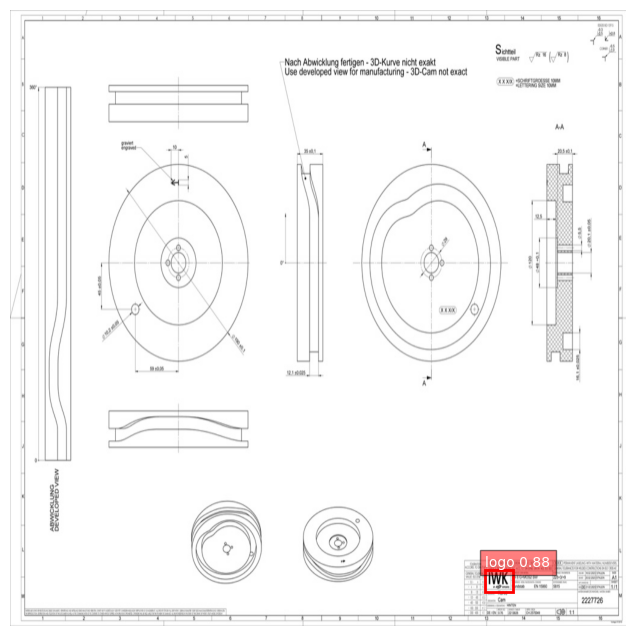

In [3]:


def load_and_preprocess_image(image_path: str) -> torch.Tensor:
    """
    Summary: Load and preprocess an image for YOLO model input
    
    Args:
        image_path (str): Path to the image file
        
    Returns:
        torch.Tensor: Preprocessed image tensor of shape (3,640,640)
    """
    # Load image
    image = Image.open(image_path).convert('RGB')  # Ensure 3 channels
    
    # Define transforms
    transform = transforms.Compose([
        transforms.Resize((1024, 1024)),  # Resize to model's expected dimensions
        transforms.ToTensor(),
        # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Standard normalization
    ])
    
    # Apply transforms
    return transform(image)

# Load test image
image_path = "/home/chogerlate/Documents/github/logo-detection/logo_detection_dataset/datasets/annotated_drawings/val/images/ed05a792-2227726_00.jpeg"
test_image = load_and_preprocess_image(image_path)


# Load model and class names
model = YOLO('/home/chogerlate/Documents/github/logo-detection/weights/logo_detection_weight.pt')

# Get class names from model
class_names = model.names

pred_results = yolov11n_inference(model, test_image)

# Visualize results
visualize_predictions(test_image, pred_results, class_names)


In [5]:
import utils as u 
import os 
from glob import glob

def batch_process_images(
    model: YOLO,
    image_paths: List[str],
    output_dir: str = './temp',
    batch_size: int = 4,
    conf_threshold: float = 0.5,
    iou_threshold: float = 0.5
) -> List[str]:
    """
    Summary: Process multiple images in batches using YOLO model for object detection and cropping
    
    Args:
        model (YOLO): Loaded YOLO model
        image_paths (List[str]): List of paths to input images
        output_dir (str): Directory to save cropped objects
        batch_size (int): Number of images to process at once
        conf_threshold (float): Confidence threshold for detections
        iou_threshold (float): IoU threshold for NMS
        
    Returns:
        List[str]: List of paths to saved cropped objects
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    cropped_paths = []
    
    # Process images in batches
    for i in range(0, len(image_paths), batch_size):
        batch_paths = image_paths[i:i + batch_size]
        
        # Get predictions for batch
        results = u.predict_with_yolo(model, batch_paths, conf=conf_threshold)
        
        # Process each image's results
        for img_path, result in zip(batch_paths, results):
            detections = result.boxes.data.cpu()
            
            if len(detections) == 0:
                continue
                
            # Apply NMS to filter detections
            filtered_detections = u.apply_nms(detections, iou_threshold)
            
            # Load original image
            original_image = u.load_image_cv2(img_path)
            base_name, ext = u.extract_base_name_and_ext(img_path)
            
            # Crop and save detected objects
            for idx, detection in enumerate(filtered_detections):
                x1, y1, x2, y2, conf, cls = map(int, detection.astype(float))
                cropped_obj = u.crop_image(original_image, x1, y1, x2, y2)
                
                # Generate output path
                output_name = f"{base_name}_obj_{idx}{ext}"
                output_path = os.path.join(output_dir, output_name)
                
                # Save cropped object
                u.save_image(cropped_obj, output_path)
                cropped_paths.append(output_path)
                    
    
            
    return cropped_paths

image_paths = list(glob('/home/chogerlate/Documents/github/logo-detection/logo_detection_dataset/datasets/annotated_drawings/train/images/*'))
model = u.load_yolo_model('/home/chogerlate/Documents/github/logo-detection/weights/logo_detection_weight.pt')

batch_process_images(model, image_paths)

['./temp/9e991b2a-2437943_00_obj_0.jpeg',
 './temp/a24e569f-2221288_00_obj_0.jpeg',
 './temp/5fce0e99-2213762_00_obj_0.jpeg',
 './temp/d7b1c90c-2124374_00_obj_0.jpeg',
 './temp/d0c815bf-2430576_00_obj_0.jpeg',
 './temp/74e35c76-2062813_08_obj_0.jpeg',
 './temp/08b2aae3-1633042_obj_0.jpeg',
 './temp/90ae5d45-2063356_02_obj_0.jpeg',
 './temp/dd8ea634-2428041_01_obj_0.jpeg',
 './temp/a09cd070-2213763_00_obj_0.jpeg',
 './temp/1f5a82d9-2419761_00_obj_0.jpeg',
 './temp/2546e714-2213761_00_obj_0.jpeg',
 './temp/40d189cb-2483526_00_washer_obj_0.jpeg',
 './temp/0e80d3c4-4999_01_obj_0.jpeg',
 './temp/9d6faa7f-2114569_02_obj_0.jpeg',
 './temp/2bb72e11-2437924_00_obj_0.jpeg',
 './temp/de66ac21-2510168_02_obj_0.jpeg',
 './temp/59a924fa-2215138_00_obj_0.jpeg',
 './temp/11f0615b-2489247-f000_00_obj_0.jpeg',
 './temp/1e715809-2213764_00_obj_0.jpeg',
 './temp/cc755870-2432507_00_obj_0.jpeg',
 './temp/7034558b-2219336_00_obj_0.jpeg',
 './temp/62dfcffc-2419075_obj_0.jpeg',
 './temp/d03aa688-1078970_02_ob